# TF-IDF + ANN for Sentiment Analysis

## Import Libraries

In [23]:
# Common Python Libraries
import numpy as np
import pandas as pd
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import random
from copy import deepcopy
import json
from IPython.display import clear_output

# for cleaner output
from tqdm import tqdm

# Word Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Preprocessing
from sklearn.model_selection import train_test_split

# Neural Network model
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

# Hyper Parameter Tuning
import optuna
from optuna.exceptions import TrialPruned
from optuna.trial import TrialState
from sklearn.model_selection import GridSearchCV #hyper parameter tuning for random forest model

# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Project Seed for Reproducability
# SEED = random.randint(0, 2**32 - 1)  # Random integer between 0 and 2^32-1
SEED = 1409822842
print(SEED)

1409822842


In [24]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA not available, using CPU.")

Using GPU: NVIDIA GeForce RTX 4060


## Import Data

In [25]:
data = pd.read_csv("Data/CleanData.csv")
data = data.dropna().drop_duplicates().reset_index(drop=True)

## Train Test Split

In [26]:
test_size = 0.20
val_size = 0.10

# Splitting the data into train and temp (which will be further split into validation and test)
train_df, test_df = train_test_split(data, test_size=test_size, random_state=SEED)

# Splitting train into validation and test sets
train_df, val_df = train_test_split(train_df, test_size=val_size, random_state=SEED)

In [27]:
x_train = train_df["text"]
x_test = test_df["text"]
x_val = val_df["text"]


y_train = train_df["label"]
y_test = test_df["label"]
y_val = val_df["label"]

## Word Embedding

In [28]:
# pass the cleaned text to the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100000)  # you can change this limit
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)
x_val_tfidf = tfidf_vectorizer.transform(x_val)

In [29]:
print("Vocabulary size:", len(tfidf_vectorizer.get_feature_names_out()))
print("tfidf shape (train):", x_train_tfidf.shape)
print("tfidf shape (test):", x_test_tfidf.shape)
print("tfidf shape (val):", x_val_tfidf.shape)

Vocabulary size: 3339
tfidf shape (train): (1552, 3339)
tfidf shape (test): (432, 3339)
tfidf shape (val): (173, 3339)


## Modelling

### Data Loader

In [30]:
# Train data
x_train_tensor = torch.tensor(x_train_tfidf.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Test data
x_test_tensor = torch.tensor(x_test_tfidf.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Validation data
x_val_tensor = torch.tensor(x_val_tfidf.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


### TF-IDF ANN

#### Grid Search Setup

##### Model Builder Function

In [31]:
def define_model(trial, input_size, n_output):

    class ANN(nn.Module):
        def __init__(self):
            super().__init__()

            layers = []
            in_dim = input_size

            # Number of dense layers
            n_layers = trial.suggest_int("n_dense_layers", 1, 5)

            for i in range(n_layers):
                out_dim = trial.suggest_int(f"dense_{i}_units", 32, 512)
                dropout = trial.suggest_float(f"dense_{i}_dropout", 0.0, 0.5)

                layers.append(nn.Linear(in_dim, out_dim))
                layers.append(nn.ReLU())
                if dropout > 0:
                    layers.append(nn.Dropout(dropout))

                in_dim = out_dim  # update

            # Output layer (classification)
            layers.append(nn.Linear(in_dim, n_output))
            # DO NOT ADD ACTIVATION (CrossEntropyLoss handles softmax internally)

            self.model = nn.Sequential(*layers)

        def forward(self, x):
            return self.model(x)

    return ANN()

##### Model Objective

In [32]:
def objective(trial, n_input, n_output, train_loader, val_loader, epochs, device):
    # Reset the seed for each trial of the gridsearch
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # Parameters for early stopping
    best_f1 = 0 # Inital f1 score
    patience = 3 # number of epochs to wait without improvement before stopping
    epochs_no_improve = 0 # Epochs counter without improvement
    best_model_state = None # To store the best model weights

    # Model Initialization
    model = define_model(trial, n_input, n_output).to(device)

    # Learning rate
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)  # log-scale search

    # Optimizer Set-Up
    optimizer_name = trial.suggest_categorical("Optimizer", ["Adam", "Momentum", "AdamW"])
    optimizer = {
        "Adam": optim.Adam(model.parameters(), lr=lr),
        "Momentum": optim.SGD(model.parameters(),
                            lr=lr,
                            momentum=trial.suggest_float("sgd_momentum", 1e-5, 1, log=True)),
        "AdamW": optim.AdamW(model.parameters(),
                            lr=lr,
                            weight_decay=trial.suggest_float("adamw_weight_decay", 1e-5, 1, log=True))
    }[optimizer_name]

    # Loss function
    loss_function = nn.CrossEntropyLoss() # Multi-class classification loss function

    for epoch in tqdm(range(epochs), desc="Training model..."):
        # Training loop
        model.train()
        for inputs, true_values in train_loader:
            inputs, true_values = inputs.to(device), true_values.to(device) # Set the device to train on

            optimizer.zero_grad() # Resets all the gradients since pytorch accumulates gradients from previous training
            outputs = model(inputs) # Runs a forward pass
            loss = loss_function(outputs, true_values) # Calculates the error
            loss.backward() # Runs a Backward pass
            optimizer.step() # Updates model trainable parameters

        # Early Stopping Check
        # Validation (after training loop finishes)
        model.eval() # Make model in evaluation mode
        all_preds = [] # For the model predictions and true lables
        all_labels = []

        with torch.no_grad(): # Turns off gradient tracking for speeding up validation, saves memory, lock memory weights
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device) # move lables to the device
                outputs = model(inputs) # Pass input data to the model to get raw logits
                _, predicted = torch.max(outputs, 1) # gets the predicted values. Since torch.max outputs max_values(confidence), and predictions

                all_preds.extend(predicted.cpu().numpy()) # move the predictions and lables to the cpu since numpy only works on CPU memory. then convert to numpy arrays then append to the list.
                all_labels.extend(labels.cpu().numpy())

        # Calculate F1 Score
        f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0) # Calculate f1 score weighted since there are class imbalances

        if f1 > best_f1:
            best_f1 = f1
            epochs_no_improve = 0
            best_model_state = deepcopy(model.state_dict()) # Save the model state
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                tqdm.write(f"Early stopping at epoch {epoch} with f1_score: {f1}")
                break

    # Load best model weights for reporting
    model.load_state_dict(best_model_state)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    tqdm.write(f"Trial {trial.number}: Best F1 Score = {f1:.4f}")
    trial.set_user_attr("best_model_state", best_model_state)
    return f1

#### Initiate Training

In [33]:
# Get Input Size
input_size = x_train_tfidf.shape[1]

# Get number of outputs
output_size = y_train.nunique()
epochs = 50
n_trials = 100

samplers = optuna.samplers.TPESampler(n_startup_trials=20) # Bayesian optimization method used by Optuna to sample hyperparameters intelligently (20 random trials first before starting the Bayesian optimization.)
study = optuna.create_study(direction="maximize", sampler=samplers) # Maximize f1 score

# Tqdm for cleaner output
progress_bar = tqdm(total=n_trials, desc="Trial", ncols=80)

for _ in tqdm(range(n_trials)):
    clear_output(wait=True) # comment this out of you want to see the whole training process
    study.optimize(lambda trial: objective(trial, input_size, output_size, train_loader, val_loader, epochs, device),
                   n_trials=1, timeout=5000)

# Summarize study results
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED]) # get the pruned trials
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE]) # get the succeeded trials

print("\nStudy statistics:")
print(f"  Finished trials: {len(study.trials)}")
print(f"  Pruned trials:   {len(pruned_trials)}")
print(f"  Complete trials: {len(complete_trials)}")

trial = study.best_trial

# Define model with best params
best_trial = study.best_trial
print("Best trial:")
print(f"  F1 Score: {best_trial.value:.4f}")
best_model = define_model(best_trial, input_size, output_size).to(device)
print("Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Load best weights
best_model.load_state_dict(best_trial.user_attrs["best_model_state"])








                                                                 
                                                                             
Training model...:  10%|█         | 5/50 [00:00<00:05,  7.80it/s]
                                                
100%|██████████| 100/100 [01:04<00:00,  1.56it/s]

Early stopping at epoch 5 with f1_score: 0.7077121396393319
Trial 99: Best F1 Score = 0.7102

Study statistics:
  Finished trials: 100
  Pruned trials:   0
  Complete trials: 100
Best trial:
  F1 Score: 0.7980
Best hyperparameters:
  n_dense_layers: 1
  dense_0_units: 338
  dense_0_dropout: 0.26566216153582833
  learning_rate: 0.0006786812621794948
  Optimizer: AdamW
  sgd_momentum: 6.777725547825189e-05
  adamw_weight_decay: 0.0407097703222319


<All keys matched successfully>

#### Model Evaluation

##### Model Builder from Parameters

In [34]:
def define_model(trial, input_size, n_output):

    class ANN(nn.Module):
        def __init__(self):
            super().__init__()

            layers = []
            in_dim = input_size

            # Number of dense layers
            n_layers = trial.suggest_int("n_dense_layers", 1, 5)

            for i in range(n_layers):
                out_dim = trial.suggest_int(f"dense_{i}_units", 32, 512)
                dropout = trial.suggest_float(f"dense_{i}_dropout", 0.0, 0.5)

                layers.append(nn.Linear(in_dim, out_dim))
                layers.append(nn.ReLU())
                if dropout > 0:
                    layers.append(nn.Dropout(dropout))

                in_dim = out_dim  # update

            # Output layer (classification)
            layers.append(nn.Linear(in_dim, n_output))
            # DO NOT ADD ACTIVATION (CrossEntropyLoss handles softmax internally)

            self.model = nn.Sequential(*layers)

        def forward(self, x):
            return self.model(x)

    return ANN()

In [35]:
def define_model_from_params(params: dict, input_size: int, n_output: int):
    class ANN(nn.Module):
        def __init__(self):
            super().__init__()

            dense_layers = []
            in_dim = input_size

            # Number of dense layers
            n_layers = params["n_dense_layers"]

            for i in range(n_layers):
                out_size = params[f"dense_{i}_units"]
                dense_layers.append(nn.Linear(in_dim, out_size))

                # Activation
                dense_layers.append(nn.ReLU())

                # Dropout
                dropout_rate = params[f"dense_{i}_dropout"]
                if dropout_rate > 0:
                    dense_layers.append(nn.Dropout(dropout_rate))

                in_dim = out_size

            # Output layer (raw logits for CrossEntropyLoss)
            dense_layers.append(nn.Linear(in_dim, n_output))

            self.model = nn.Sequential(*dense_layers)

        def forward(self, x):
            return self.model(x)

    return ANN()

##### Model Evaluation Function

In [36]:
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)

    # classification report
    class_report = classification_report(all_labels, all_preds, zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    return f1, recall, precision, class_report, cm, all_preds, all_labels

In [38]:
tfidf_model_pytorch_path = "models/tfIDF_ANN_model.pt"
tfidf_model_json_path = "models/tfIDF_ANN_model.json"
seed_path = "models/tfIDF_ANN_SEED.txt"
new_tfidf_model = best_model.to(device)
new_tfidf_model.eval()

# Evaluate new model on test set
new_f1, new_recall, new_precision, new_class_report, new_cm, _, _ = evaluate_model(
                                                    new_tfidf_model,
                                                    test_loader,
                                                    device
                                                    )

if os.path.exists(tfidf_model_pytorch_path) and os.path.exists(tfidf_model_json_path):
    # Load the existing (old) model
    with open(tfidf_model_json_path, "r") as f:
        best_tfidf_params = json.load(f)

    old_tfidf_model = define_model_from_params(best_tfidf_params, input_size, output_size).to(device)
    old_tfidf_model.load_state_dict(torch.load(tfidf_model_pytorch_path))
    old_tfidf_model.eval()

    # Evaluate the old model
    old_f1, old_recall, old_precision, old_class_report, old_cm, _, _ = evaluate_model(
        old_tfidf_model,
        test_loader,
        device
    )
    print("Model Scores:")
    print(f"Old_f1          = {old_f1:.4f}          | New_f1        = {new_f1:.4f}")
    print(f"Old_recall      = {old_recall:.4f}          | New_recall    = {new_recall:.4f}")
    print(f"Old_precision   = {old_precision:.4f}          | New_precision = {new_precision:.4f}")
    print()
    print()
    print("Old Cllassification Report:")
    print(old_class_report)
    print()
    print()
    print("New Cllassification Report:")
    print(new_class_report)

    if new_f1 > old_f1:
        print("🔁 New model is better — overwriting saved model.")
        torch.save(new_tfidf_model.state_dict(), tfidf_model_pytorch_path)
        with open(tfidf_model_json_path, "w") as f:
            json.dump(best_trial.params, f, indent=4)
        with open(seed_path, "w") as file:
            file.write(str(SEED))
        tfidf_model = new_tfidf_model
    else:
        print("✅ Existing model is still better.")
        tfidf_model = old_tfidf_model
else:
    print("📥 No existing model — saving new model.")
    os.makedirs(os.path.join(project_path, "models"), exist_ok=True)
    torch.save(new_tfidf_model.state_dict(), tfidf_model_pytorch_path)
    with open(tfidf_model_json_path, "w") as f:
        json.dump(best_trial.params, f, indent=4)
    with open(seed_path, "w") as file:
        file.write(str(SEED))
    tfidf_model = new_tfidf_model



📥 No existing model — saving new model.


##### Classification Report

In [39]:
_, _, _, tfIDF_ANN_Class_report, tfIDF_ANN_cm, _, _ = evaluate_model(tfidf_model, test_loader, device)
print(tfIDF_ANN_Class_report)

              precision    recall  f1-score   support

           0       0.82      0.94      0.87       309
           1       0.67      0.46      0.54        81
           2       0.68      0.36      0.47        42

    accuracy                           0.79       432
   macro avg       0.72      0.58      0.63       432
weighted avg       0.78      0.79      0.77       432



##### Confusion Matrix

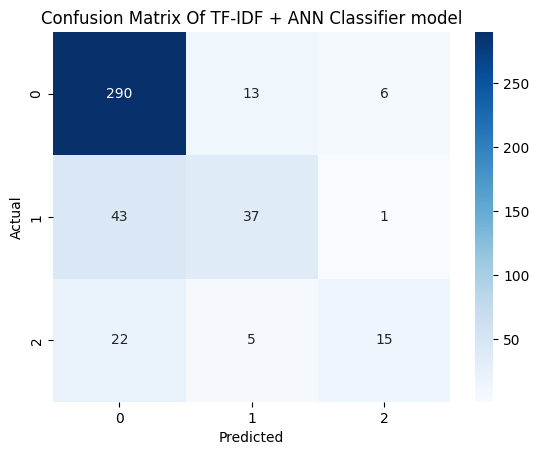

In [40]:
sns.heatmap(
    tfIDF_ANN_cm,
    cmap= "Blues",
    annot= True,
    fmt= "g"
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Of TF-IDF + ANN Classifier model")

plt.show()